In [1]:
from tensorflow.keras.datasets import cifar10
import tensorflow  as tf
import numpy as np
import pandas as pd
import os
from PIL import Image
from tensorflow.keras import layers, models, callbacks
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2

import matplotlib.pyplot as plt

In [2]:
# 1) CIFAR-10 load  ----------------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [3]:

# 2) check shapes ---------------------------------
print(f"Train images : {x_train.shape}")   # (50000, 32, 32, 3)
print(f"Train labels : {y_train.shape}")   # (50000, 1)
print(f"Test  images : {x_test.shape}")    # (10000, 32, 32, 3)
print(f"Test  labels : {y_test.shape}")    # (10000, 1)

Train images : (50000, 32, 32, 3)
Train labels : (50000, 1)
Test  images : (10000, 32, 32, 3)
Test  labels : (10000, 1)


# CONSTANTS (hyper-parameters & config)

In [4]:
NUM_CLASSES   = 10                    # CIFAR-10 → 10 classes
INPUT_SHAPE   = (32, 32, 3)           # H x W x C #from cfr10 site.
IMG_SIZE = 224 # RESNET needs 224 X 224 X 3 IMAGES
CLASS_NAMES   = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"

]
EPOCHS=30
BATCH_SIZE = 64
VAL_RATIO    = 0.1                # 10 % validation

# train validation test split and preprocess

In [5]:
# Flatten labels from shape (N,1) to (N,) to avoid NumPy warning
y_train = y_train.flatten()
y_test  = y_test.flatten()

In [6]:
# ------------------------------------------------
# 3) Train → (train + val)
# ------------------------------------------------
num_val          = int(len(y_train) * VAL_RATIO)          # 5 000
x_val, y_val     = x_train[-num_val:], y_train[-num_val:]
x_train, y_train = x_train[:-num_val], y_train[:-num_val]

In [7]:
# CREATE DATASETS
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  
    layers.RandomRotation(0.2),                    # ±20% → ~±36°
])

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255),
])

# 1) Preprocess for training (augmentation + normalization)
def preprocess_train(img, label):
    img = data_augmentation(img, training=True)  # only active during training
    img = resize_and_rescale(img)
    return img, label

# 2) Preprocess for validation/test (only normalization)
def preprocess_eval(img, label):
    img = resize_and_rescale(img)
    return img, label                      # apply one-hot here if needed

train_ds = train_ds.map(
    preprocess_train,            # augmentation + normalization
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(
    preprocess_eval,             # only normalization
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(
    preprocess_eval,             # only normalization
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)


In [8]:

print(f"Train images : {len(x_train)}")
print(f"Val   images : {len(x_val)}")
print(f"Test  images : {len(x_test)}")

Train images : 45000
Val   images : 5000
Test  images : 10000


## samples

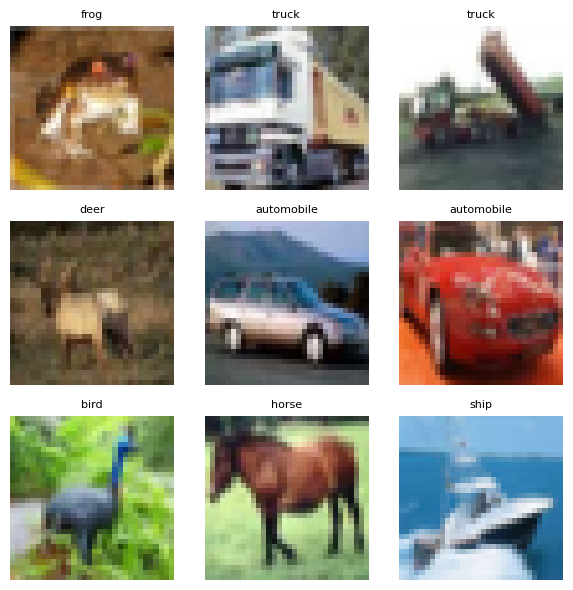

In [9]:
# Pick 9 samples (first 9 for simplicity)
num_samples = 9
samples = x_train[:num_samples]
labels  = y_train[:num_samples]

# Plot
plt.figure(figsize=(6, 6))
for i, (img, label) in enumerate(zip(samples, labels)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(CLASS_NAMES[label], fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

# RESNET TRANSFER LEARNING

In [10]:
# ------------------------------------------------------------------
#  Build the ResNet50V2 transfer-learning model
# ------------------------------------------------------------------
base_model = ResNet50V2(
    include_top=False,          # drop the 1000-class FC head
    weights="imagenet",         # load ImageNet weights
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling="max",              # add GlobalMaxPooling2D automatically
    name="resnet50v2",
)
base_model.trainable = False    # freeze backbone for the first stage. our model will not change this models values by this.



94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


implement our model

In [20]:
model = models.Sequential([
    base_model,                                 # Pre-trained backbone
    layers.Dense(256, activation='relu'),       # Intermediate layer: 256 neurons
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer
])
model.summary()


Let's compile the model, starting with a small learning rate

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# **“Initial training (head only)” — Train only the head (top layers)**
# Purpose:
 To quickly adapt only the classifier (Dense + Dropout + Output) layers you added to your new classification task,
 without disturbing the pre-trained backbone (base_model) weights learned on ImageNet.

# Why train only the head first?

- Shorter training time (far fewer parameters are updated).
- The backbone already works well as a feature extractor, so first training a head that adapts to new labels gives stable results.
- Trying to fine-tune the entire network from the start, especially with a small dataset, can sometimes lead to poor outcomes (weights may get disrupted).


In [13]:
history_head = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 131s 162ms/step - accuracy: 0.4554 - loss: 1.9594 - val_accuracy: 0.7448 - val_loss: 0.7285
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 98s 139ms/step - accuracy: 0.6169 - loss: 1.0819 - val_accuracy: 0.7662 - val_loss: 0.6520
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 139ms/step - accuracy: 0.6474 - loss: 1.0050 - val_accuracy: 0.7868 - val_loss: 0.6029
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 139ms/step - accuracy: 0.6520 - loss: 0.9832 - val_accuracy: 0.7724 - val_loss: 0.6303
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 139ms/step - accuracy: 0.6639 - loss: 0.9488 - val_accuracy: 0.7854 - val_loss: 0.6092
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 143s 140ms/step - accuracy: 0.6671 - loss: 0.9418 - val_accuracy: 0.7854 - val_loss: 0.6027
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 98s 140ms/step - accuracy: 0.6690 - loss: 0.9264 - val_accuracy: 0.7800 - val_loss: 0.6320
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 140ms/step - accuracy: 0.6730 - l

In [14]:
acc = history_head.history['accuracy']
val_acc = history_head.history['val_accuracy']

loss = history_head.history['loss']
val_loss = history_head.history['val_loss']

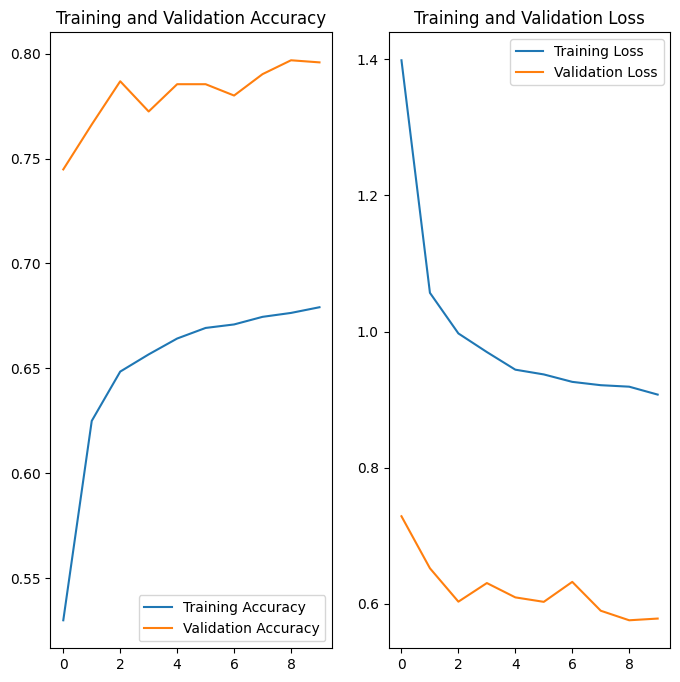

In [16]:
EPOCHS = 10
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 152s 197ms/step - accuracy: 0.7378 - loss: 0.8347 - val_accuracy: 0.8776 - val_loss: 0.3913
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 122s 173ms/step - accuracy: 0.8559 - loss: 0.4309 - val_accuracy: 0.8730 - val_loss: 0.3984
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 122s 173ms/step - accuracy: 0.8649 - loss: 0.3933 - val_accuracy: 0.8902 - val_loss: 0.3508
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 173ms/step - accuracy: 0.8768 - loss: 0.3653 - val_accuracy: 0.8864 - val_loss: 0.3603
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 122s 173ms/step - accuracy: 0.8824 - loss: 0.3559 - val_accuracy: 0.8776 - val_loss: 0.3861
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 173ms/step - accuracy: 0.8858 - loss: 0.3381 - val_accuracy: 0.8890 - val_loss: 0.3384
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 122s 173ms/step - accuracy: 0.8925 - loss: 0.3168 - val_accuracy: 0.8844 - val_loss: 0.3725
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 174ms/step - accuracy: 0.8956 -

In [22]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

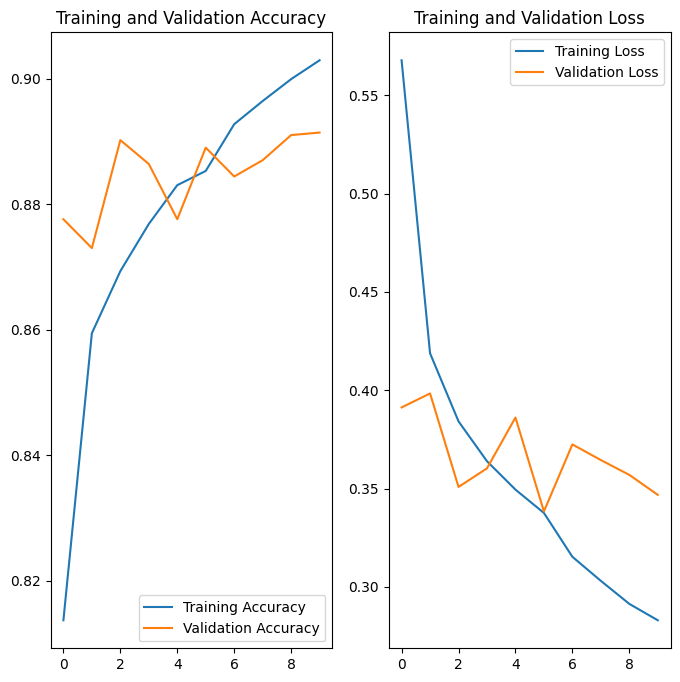

In [23]:
EPOCHS = 10
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.3f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.8855 - loss: 0.3681
Test doğruluğu: 0.888


In [25]:
import numpy as np
from sklearn.metrics import classification_report

# 1) Tüm test etiketlerini ve tahminleri al
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

# 2) Sınıf isimlerinizi daha önce tanımlamıştınız:
CLASS_NAMES = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

# 3) Raporu yazdırın
print(classification_report(
    y_true, y_pred,
    target_names=CLASS_NAMES,
    digits=4
))


157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step
              precision    recall  f1-score   support

    airplane     0.9393    0.8980    0.9182      1000
  automobile     0.9473    0.9520    0.9496      1000
        bird     0.8556    0.8710    0.8632      1000
         cat     0.8326    0.7560    0.7925      1000
        deer     0.8482    0.8490    0.8486      1000
         dog     0.8398    0.8600    0.8498      1000
        frog     0.8694    0.9390    0.9029      1000
       horse     0.8934    0.8970    0.8952      1000
        ship     0.9582    0.9180    0.9377      1000
       truck     0.9006    0.9420    0.9208      1000

    accuracy                         0.8882     10000
   macro avg     0.8884    0.8882    0.8878     10000
weighted avg     0.8884    0.8882    0.8878     10000

